<a href="https://colab.research.google.com/github/ssec/WAF_ML_Tutorial_Part2/blob/main/colab_notebooks/Notebook08_UNets_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/colab_notebooks/Notebook08_UNets.ipynb)

# Notebook 08: U-Networks
### Primary Goal:

Build and train a "U"-Network

#### Background
As an added step of complexity, the next version of neural networks covered in the paper are called "U"-networks. U-Nets are still convolutional neural networks, but now they have a 'down' and an 'up' branch which gives the network architecture the titular "U" shape. The down (or encoding) branch of the network is used to convolve and maxpool the input data, reducing the image size. Then on the 'up' (or decoding) branch, the image is upsampled back to a higher resolution (typically matching the input's original resolution). Figure 6 of the paper is reproduced here for additional context.



<img src="https://github.com/ssec/WAF_ML_Tutorial_Part2/blob/main/images/FIg6_WAF2.png?raw=1" width="800" height="200" class="center" />



So what does a U-Net do that a CNN can't?
- The main strength of U-Nets is 'image-to-image' translation. In other words the U-Net takes in some input image and then outputs an image with the same shape as the input. For our example, we can use a U-Net to not only predict if there is lightning in the image, but also where in the image it is located.

#### Step 0: Installs and grab the data

Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient

In [1]:
#@title Install and unpack files [this will take some time]

print('installing dependencies')
!pip -q install zenodo-get
!pip -q install zarr
# Note: We are removing the keras-unet-collection install as we will implement UNet in PyTorch manually
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')


installing dependencies
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.3/252.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 137.5 MB/s eta 0:00:00
grabbing sub-sevir
Title: sub-SEVIR
Keywords: 
Publication date: 2022-09-28
DOI: 10.5281/zenodo.7011372
Total size: 2.0 GB

File: sub-sevir.tar.gz (2.0 GB)
Link: https://zenodo.org/api/records/7011372/files/sub-sevir.tar.gz/content

Checksum is correct for sub-sevir.tar.gz. (94ae916d24224500c2f531bb61440dab)

All specified files have been processed.
unpacking sub-sevir
grabbing the Github repo
Cloning into 'WAF_ML_Tutorial_Part2'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 368 (delta 140), reused 1

 #### Step 1: Imports



 As with all of our notebooks, we will first import the necessary packages.

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


#### Step 2: Define the U-Net Model

Since we are using PyTorch, we will implement the U-Net architecture manually. This gives us more control and is standard practice in PyTorch.

A U-Net consists of an encoder (downsampling path) and a decoder (upsampling path) with skip connections.

We will define `DoubleConv`, `Down`, `Up`, and `OutConv` blocks to build the full `UNet` class.

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Standard UNet structure, but reduced depth for this tutorial similar to the original keras notebook
        # Input channels: 4 (features)
        # We start with 32 filters (can be adjusted)
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)

        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)


 #### Step 3: Load in the dataset

In [4]:
ds_train = xr.open_dataset('sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir/sub-sevir-val.zarr',engine='zarr')


 Next, let's convert the data to PyTorch `Dataset` and `DataLoader`.



 #### Step 4: Make PyTorch Dataset and DataLoader



 This will be very similar to the process used in the previous notebook.  The only difference is this time we will use the ```2d``` labels instead of the ```1d``` labels.



 **Important Note on Shapes:** PyTorch expects images in `(Channel, Height, Width)` format. Our input data is likely `(Height, Width, Channel)`. We need to permute dimensions in our Dataset class.

In [5]:
class SubSevirDataset(Dataset):
    def __init__(self, xarray_dataset):
        self.features = xarray_dataset.features.values
        self.labels = xarray_dataset.label_2d_class.values # Using 2d labels now!

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Grab data
        x = self.features[idx] # (H, W, C)
        y = self.labels[idx]   # (H, W) or (H, W, 1)

        # Convert to tensor
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        # Permute Input: (H, W, C) -> (C, H, W)
        x = x.permute(2, 0, 1)

        # Ensure label has channel dim: (H, W) -> (1, H, W)
        if y.ndim == 2:
            y = y.unsqueeze(0)
        elif y.ndim == 3 and y.shape[-1] == 1:
            y = y.permute(2, 0, 1)

        return x, y

# Instantiate Datasets
train_dataset = SubSevirDataset(ds_train)
val_dataset = SubSevirDataset(ds_val)

# Set seed
torch.manual_seed(42)

# Create Loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


 Next, let's look at an example from the dataset to verify everything worked as expected.

In [6]:
# Get one batch
data_iter = iter(train_loader)
features_batch, labels_batch = next(data_iter)


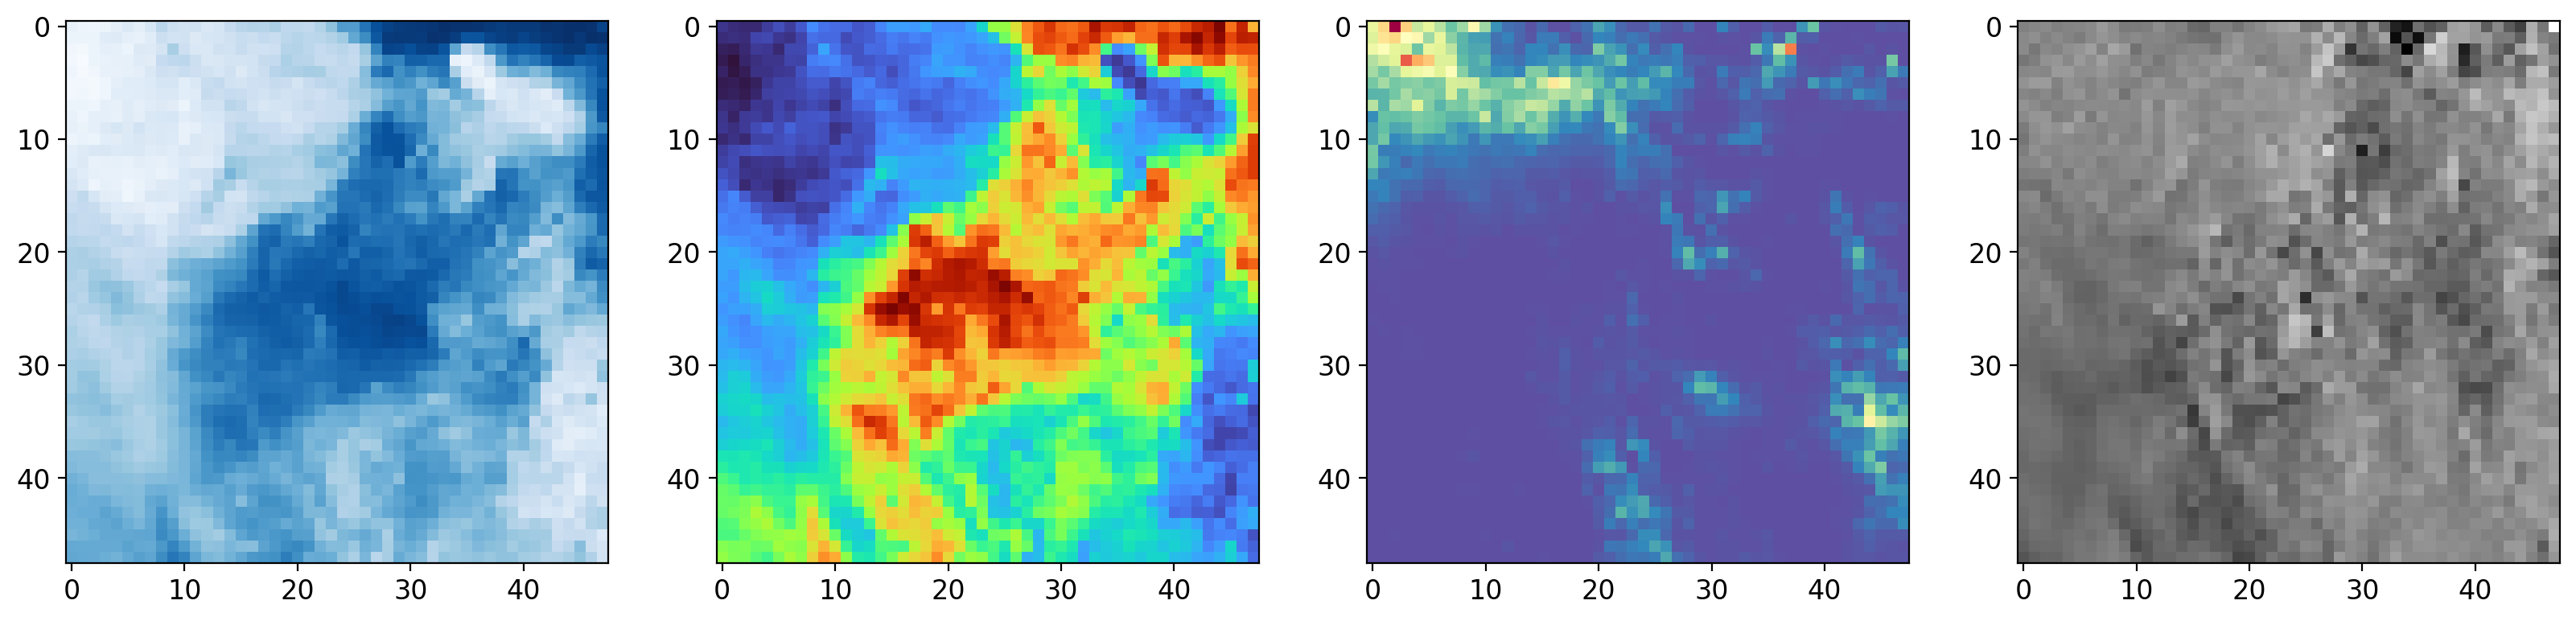

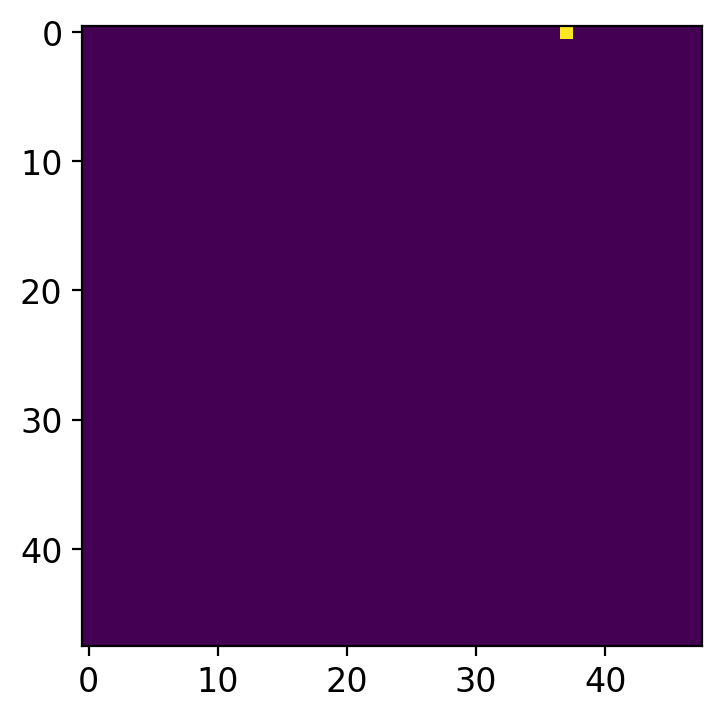

In [7]:
# Get the features for example 29 in this batch
# Permute back to HWC for plotting
one_example_features = features_batch[29].permute(1, 2, 0)
# Get the label for that same example
one_example_label = labels_batch[29].squeeze() # Remove channel dim for plotting


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

fig,axes = plt.subplots(1,1,figsize=(4,5))
axes.imshow(one_example_label)


 The first row of images is still our features (i.e., inputs), which are Water Vapor, Infrared, Radar and Visible. The second row is the label containing a map of the lightning locations. The label is 0 (blue) where there is no lightning and 1 (yellow) where there is lightning. The goal for the U-Net is to produce a map containing the probability of lightning at each pixel.



 #### Step 5: Build the model



 We initialize the `UNet` class we defined earlier.



 * `n_channels`: 4 (Our 4 weather features)

 * `n_classes`: 1 (Probability map of lightning)

In [8]:
# Initialize model
model = UNet(n_channels=4, n_classes=1).to(device)

print(model)


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.

 #### Step 6: Run some data through



 Okay, let's run some data through the untrained model just to see what a randomly weighted model looks like:

(0.0, 1.0)

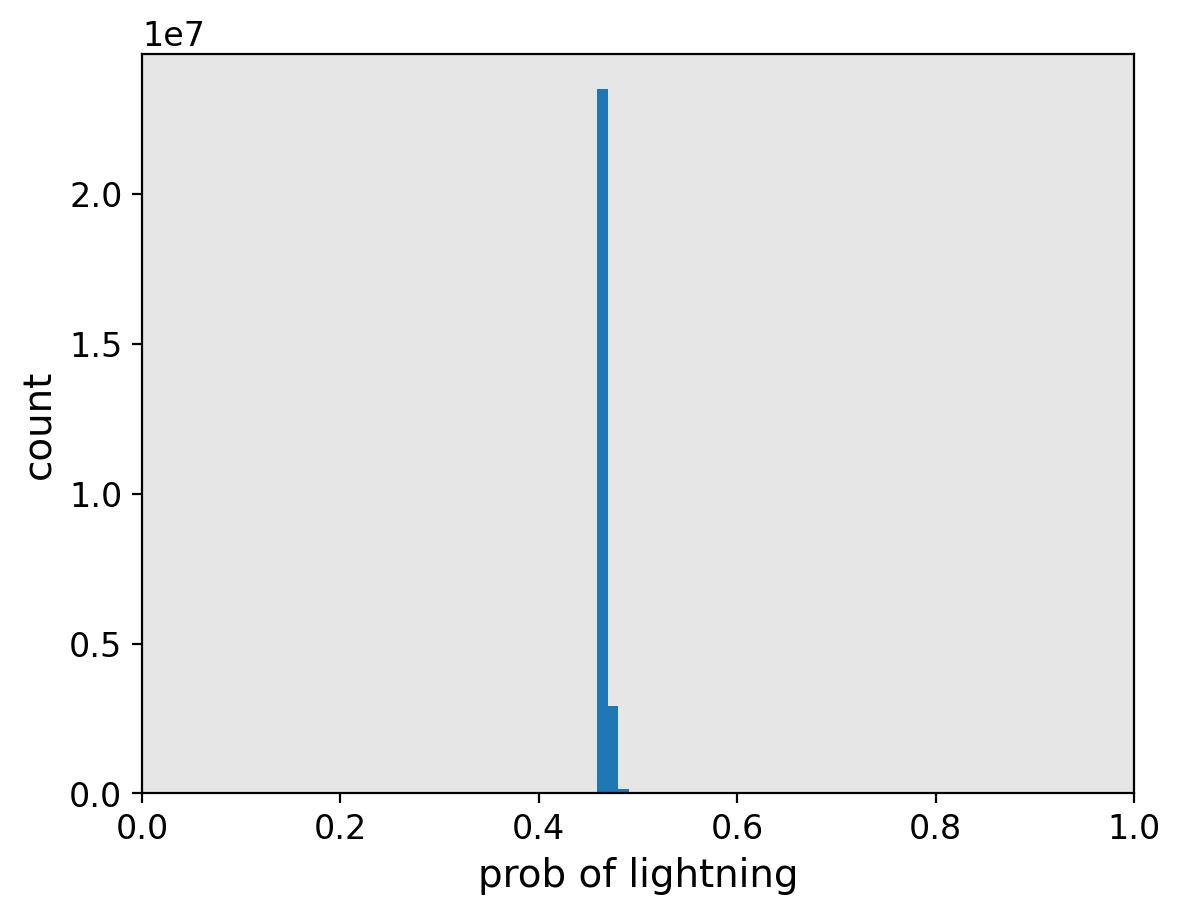

In [9]:
# Helper function for predictions
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            preds = model(inputs)
            all_preds.append(preds.cpu().numpy())
    return np.concatenate(all_preds)

y_preds = get_predictions(val_loader, model)

plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 The results are a bit different this time. It looks like most of the predictions are near 0.5, which could be expected for random weights. Let's look at an example:

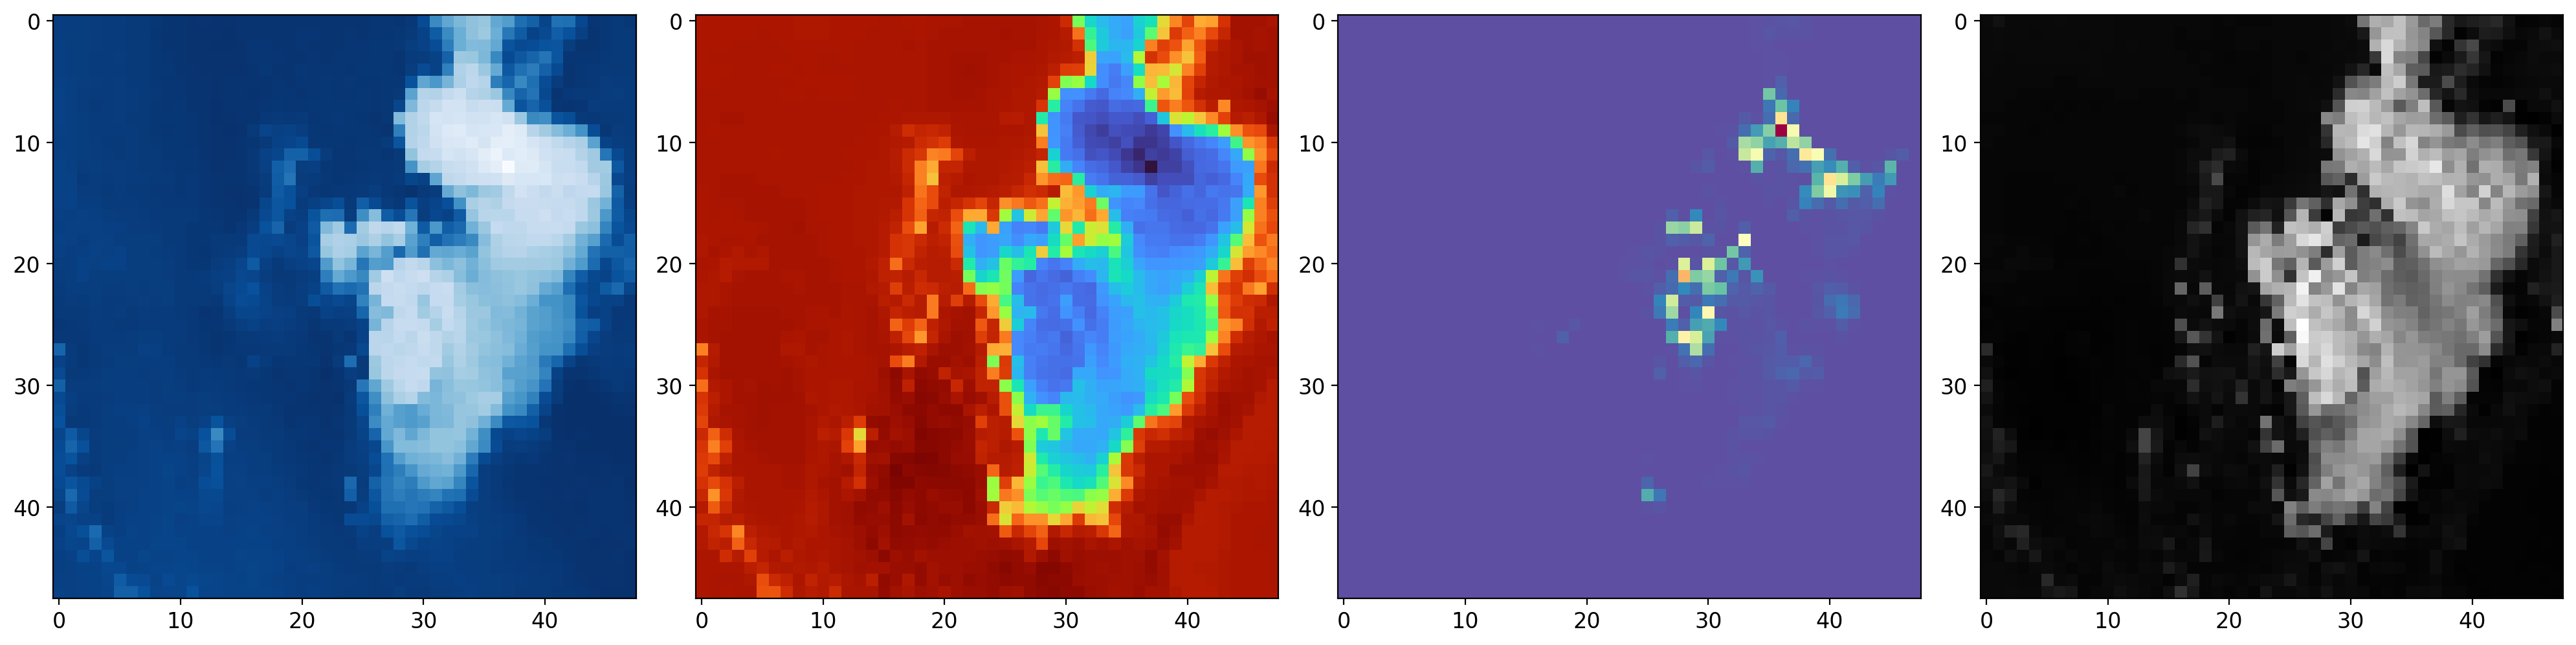

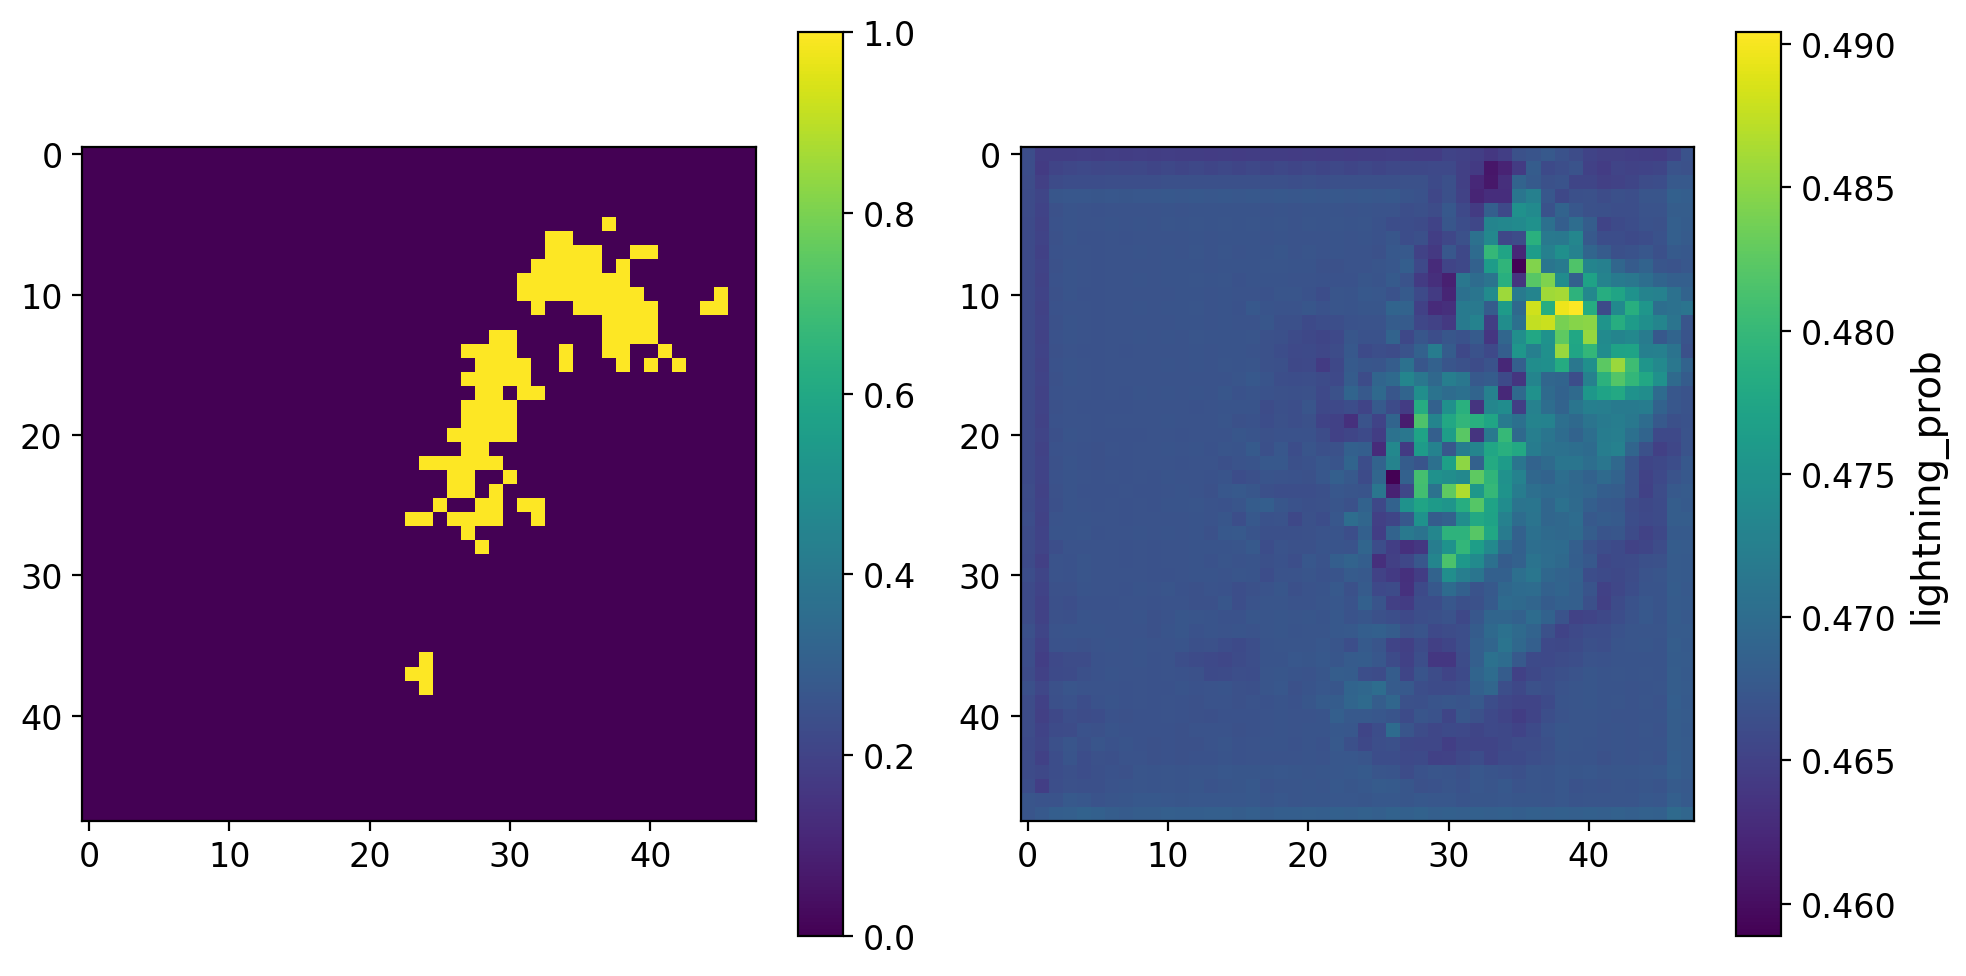

In [10]:
# Get the features for example 27 in this batch (from the validation loader iteration)
# We need to manually iterate the val_loader to get matching batch data for visualization
val_iter = iter(val_loader)
val_features_batch, val_labels_batch = next(val_iter)

one_example_features = val_features_batch[27].permute(1, 2, 0)
one_example_label = val_labels_batch[27].squeeze()
one_example_pred = y_preds[27].squeeze() # Remove channel dim (1, 48, 48) -> (48, 48)

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5))
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(one_example_pred, vmin=0, vmax=1))
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()


 As expected, the untrained model appears to be randomly guessing where the lightning is in the image.



 #### Step 7: Compile and train



 We define our optimizer (Adam) and loss function (Binary Cross Entropy).

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

epochs = 5
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/5 - Loss: 0.0775 - Val Loss: 0.0267
Epoch 2/5 - Loss: 0.0233 - Val Loss: 0.0256
Epoch 3/5 - Loss: 0.0217 - Val Loss: 0.0231
Epoch 4/5 - Loss: 0.0211 - Val Loss: 0.0225
Epoch 5/5 - Loss: 0.0207 - Val Loss: 0.0226


 This may take some time to run depending on your computer. On my particular Macbook Pro, the training takes ~ 1 min per epoch. However, if you are running this on Google Colab, the training should run much faster if you have the GPU enabled. This is where the power of GPUs can be really useful for machine learning. You can run many more training sessions when the code takes ~ 10s per epoch instead of 1 min.



 #### Step 8: Run data through 'trained' model



 Like before, let's run some data through our newly trained network





(0.0, 1.0)

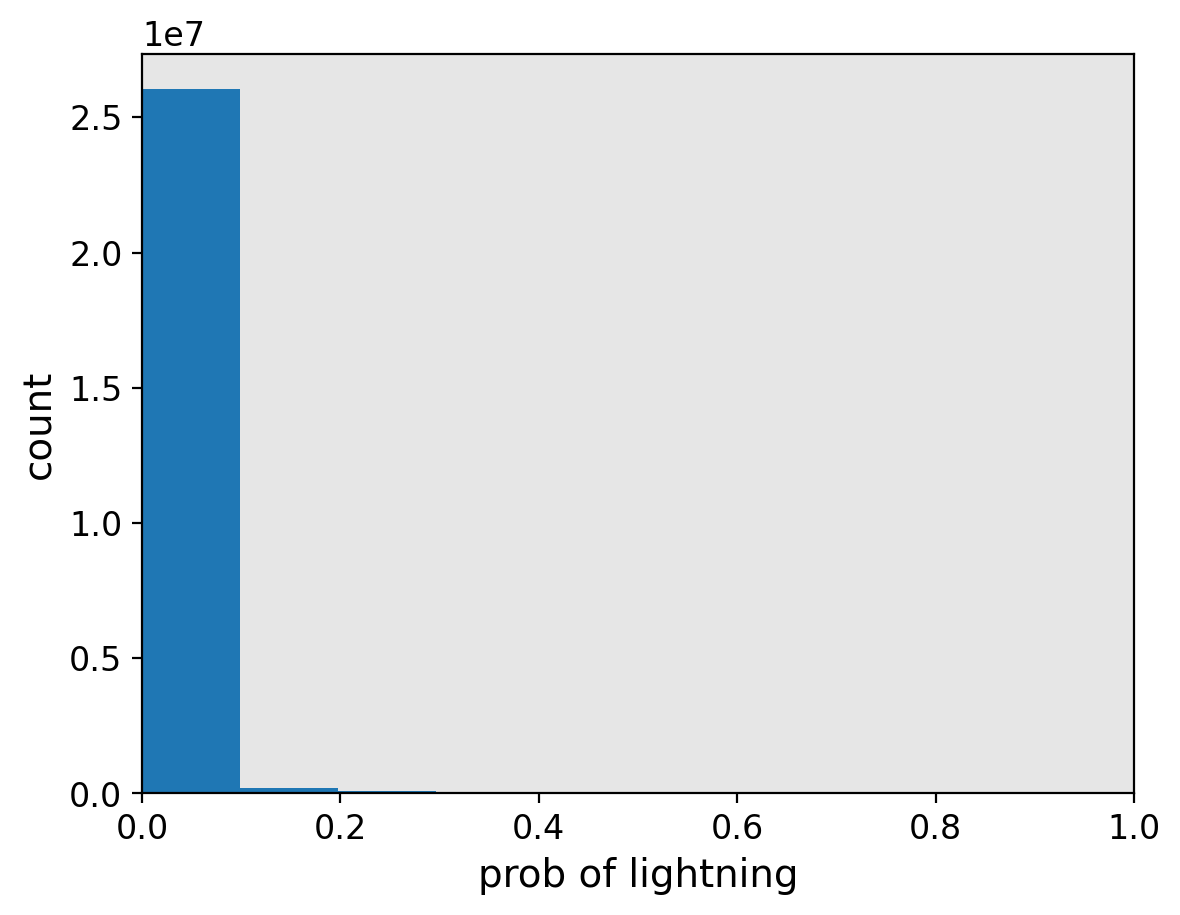

In [12]:
y_preds = get_predictions(val_loader, model)

plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 Now most of the output is 0. This is not surprising as lightning is a rare event within the pixels of each image in the dataset.  That is, lightning is typically observed in only a few pixels in each example. Let's see if things make sense spatially by plotting the same example we showed before:

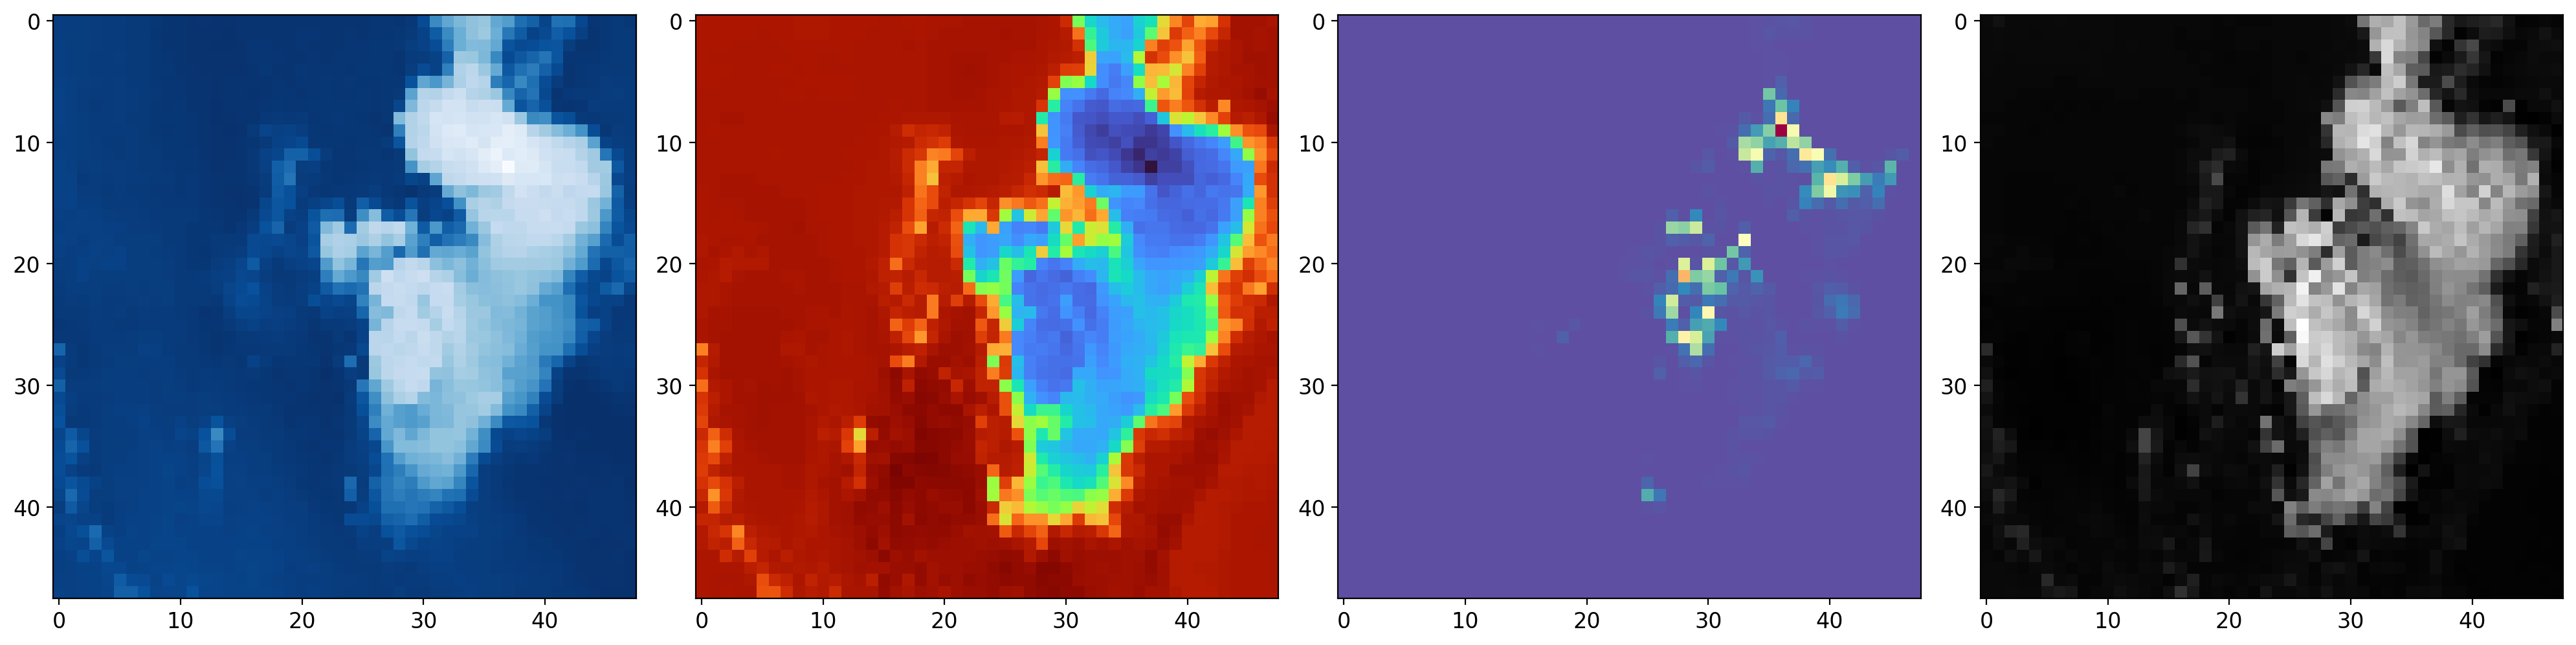

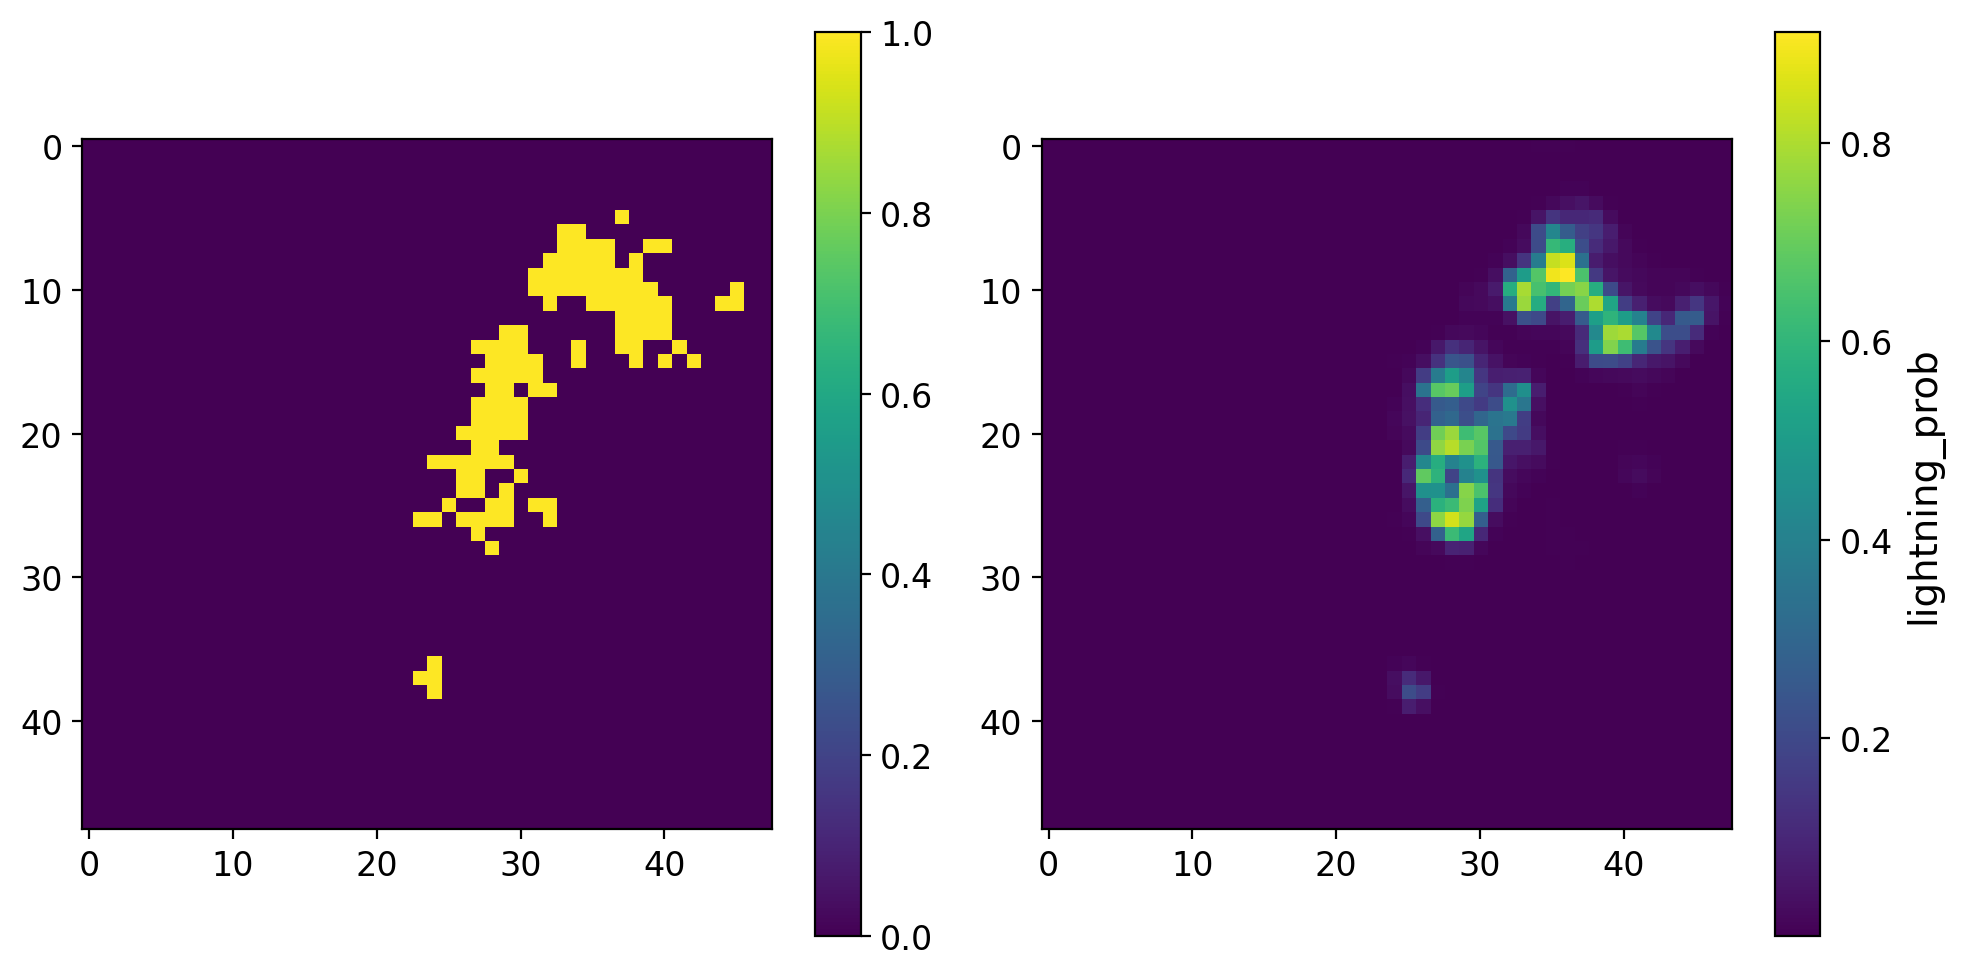

In [13]:
# Visualizing the 27th example of the first batch again
# Note: y_preds corresponds to the entire validation set, so index 27 is the 27th item of the dataset.
# We need to fetch the 27th item from the dataset directly to match.
val_features, val_label = val_dataset[27]

one_example_features = val_features.permute(1, 2, 0)
one_example_label = val_label.squeeze()
one_example_pred = y_preds[27].squeeze()

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(one_example_pred)
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()


 Good! The model is at least getting the general area of lighting correct. Notice though that the probabilities are quite low (in an absolute sense). Now let's take a look at the performance diagram which should help us better assess this rare event. This will be a pixel-by-pixel analysis, so there are A LOT more samples than  in previous notebooks.



 #### Step 8: Evaluate



 First we have to get the truth values for each pixel. We are going to ravel these into a 1-d vector:

In [14]:
# Concatenate all labels from the dataset
all_labels = []
for _, label in val_loader:
    all_labels.append(label.numpy())
y_v = np.concatenate(all_labels)

#ravel both
y_v_rav = y_v.ravel()
y_preds_rav = y_preds.ravel()


In [15]:
# Calculate stats manually for performance diagram
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

# This might be slow for pixel-wise calculation on the full array
# Ideally, use GPU or optimized metrics if available
for t in thresh:
    preds_bin = (y_preds_rav >= t).astype(int)
    truth_bin = (y_v_rav == 1).astype(int)

    tp = np.sum((preds_bin == 1) & (truth_bin == 1))
    fp = np.sum((preds_bin == 1) & (truth_bin == 0))
    fn = np.sum((preds_bin == 0) & (truth_bin == 1))

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

# Avoid div by zero
with np.errstate(divide='ignore', invalid='ignore'):
    pods = tps/(tps + fns)
    srs = tps/(tps + fps)
    csis = tps/(tps + fns + fps)

pods = np.nan_to_num(pods)
srs = np.nan_to_num(srs)
csis = np.nan_to_num(csis)


/content/WAF_ML_Tutorial_Part2/scripts/gewitter_functions.py:417: SyntaxWarning: invalid escape sequence '\l'
  pretty_names = [ '$\lambda_{\downarrow}$', '$T_{d}$', '$V_{fric}$', 'Gflux', '$Cloud_{high}$',
/content/WAF_ML_Tutorial_Part2/scripts/gewitter_functions.py:419: SyntaxWarning: invalid escape sequence '\l'
  'Hours $T_{sfc}$ $>$ 0', 'Hours $T_{sfc} \leq 0$', 'SfcRough', '$T_{sfc}$',
/content/WAF_ML_Tutorial_Part2/scripts/gewitter_functions.py:420: SyntaxWarning: invalid escape sequence '\l'
  '$I_{S}$', '$T_{2m}$', 'Hours $T_{2m}$ $>$ 0', 'Hours $T_{2m}$ $\leq $ 0',


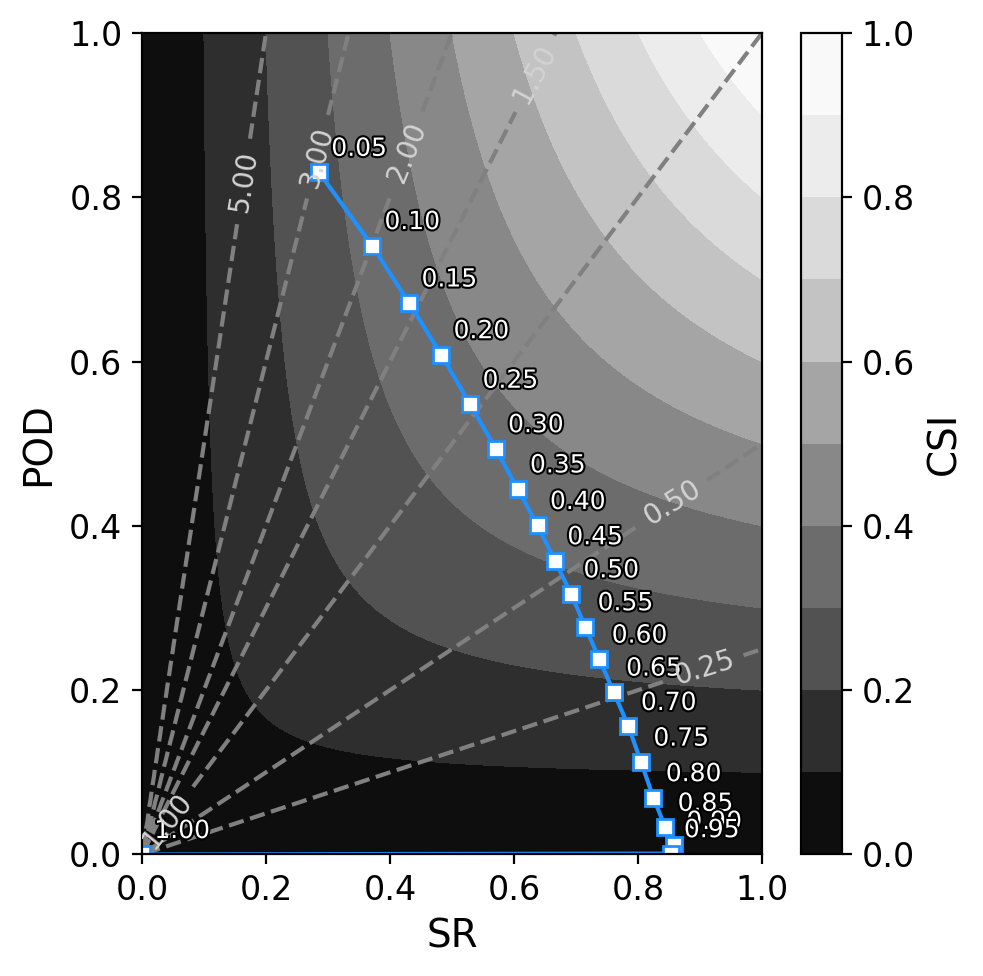

In [16]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, 'WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import make_performance_diagram_axis

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods,'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(srs[i]+0.02, pods[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()


 Overall, the performance is not that great. However, we only trained the U-Net for a limited number of epochs, so the network may not have fully converged on a solution. Also remember that this is a much more difficult classification problem than that demonstrated in the other notebooks (i.e., the ANN and CNN ones). We not only want to know if there is lightning in the image, but also *where* that lightning is. Therefore, we may need to calibrate our expectations.



 #### Step 8: Try a slightly different batch_size



 You wouldn't be able to tell at this point, but it took us a decent amount of time to find a U-Net that 'works' when trained on a CPU in a reasonable amount of time. To demonstrate the challenge, let's lower the training batch size to 32 instead of 64.



 We need to re-load the datasets and re-batch them as before:

In [17]:
# Create new Loaders
batch_size = 32
train_loader_32 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_32 = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [18]:
# Re-initialize model
model_32 = UNet(n_channels=4, n_classes=1).to(device)
optimizer = optim.Adam(model_32.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# Train
epochs = 5
for epoch in range(epochs):
    model_32.train()
    running_loss = 0.0
    for inputs, labels in train_loader_32:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_32(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader_32.dataset):.4f}")


Epoch 1 Loss: 0.0571
Epoch 2 Loss: 0.0220
Epoch 3 Loss: 0.0213
Epoch 4 Loss: 0.0210
Epoch 5 Loss: 0.0206


(0.0, 1.0)

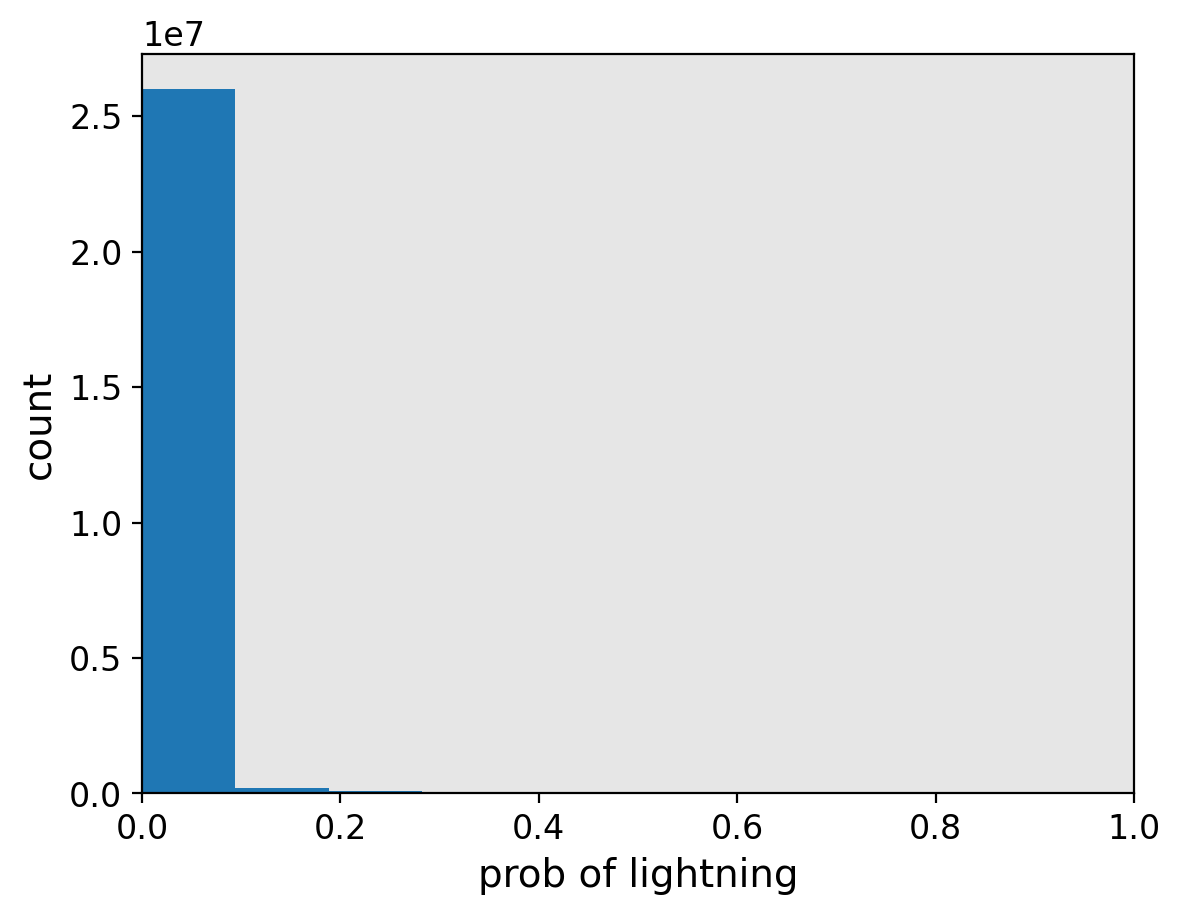

In [38]:
y_preds = get_predictions(val_loader_32, model_32)

plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 As you can see here, the lower batch size results in some *oddities*. It looks like the model is predicting one value basically everywhere. But this becomes even more clear when we look at the same example again.

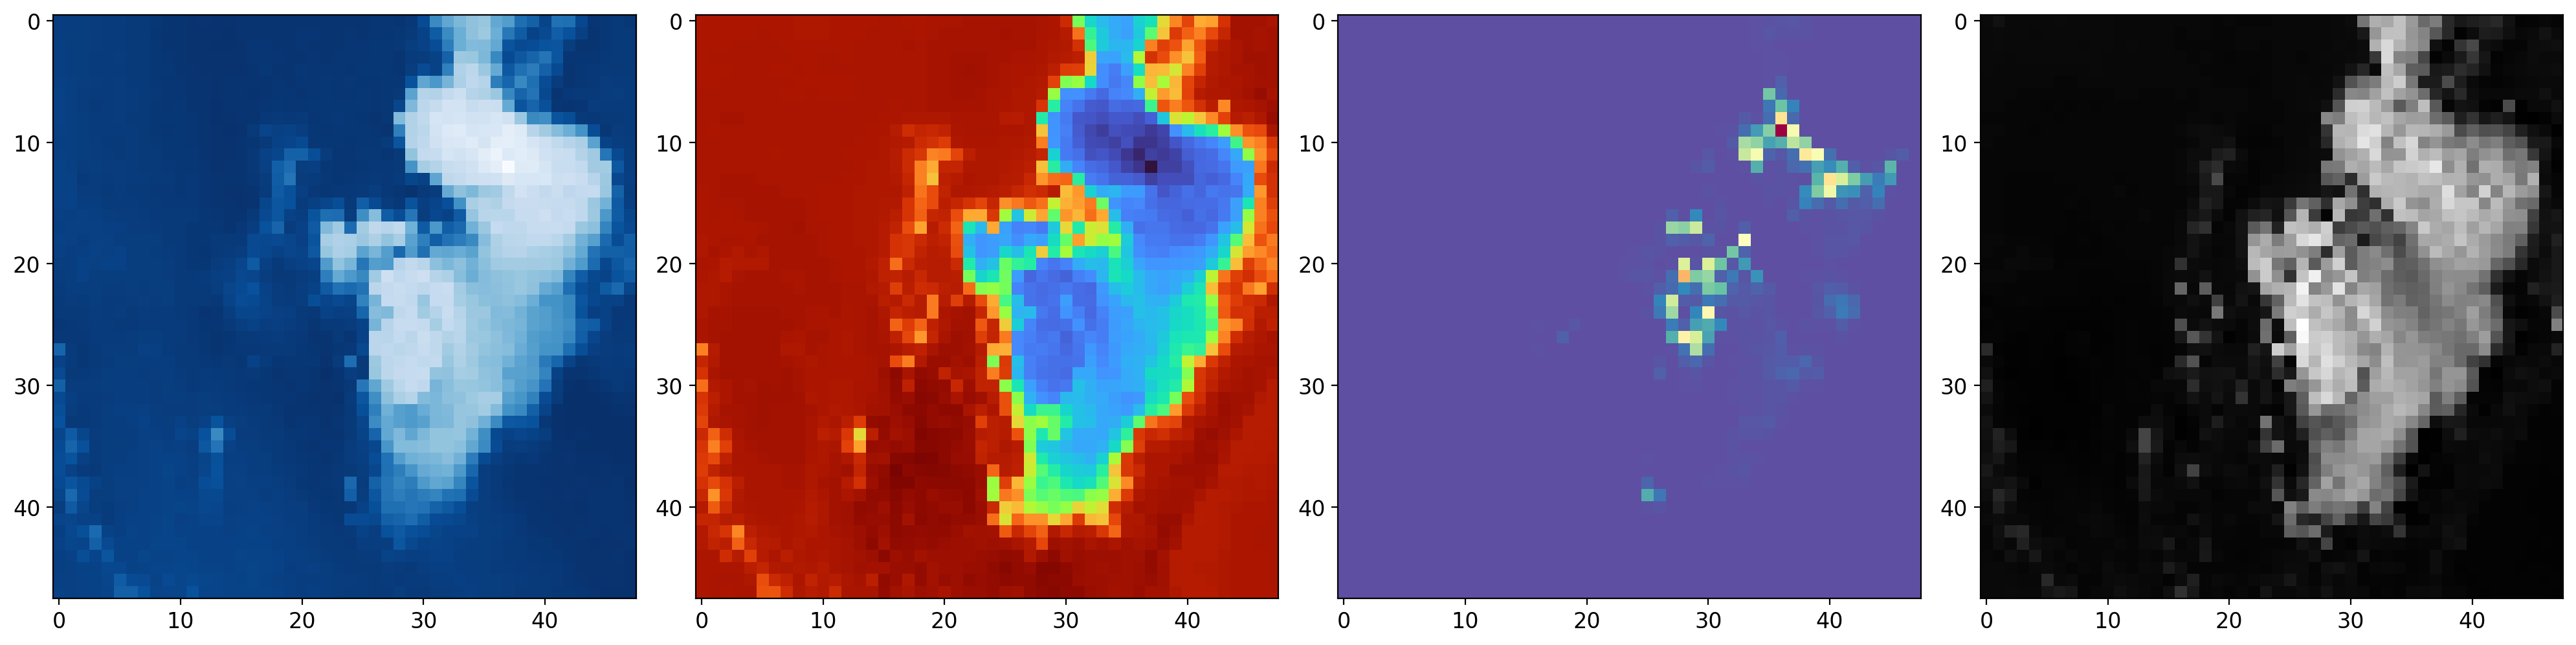

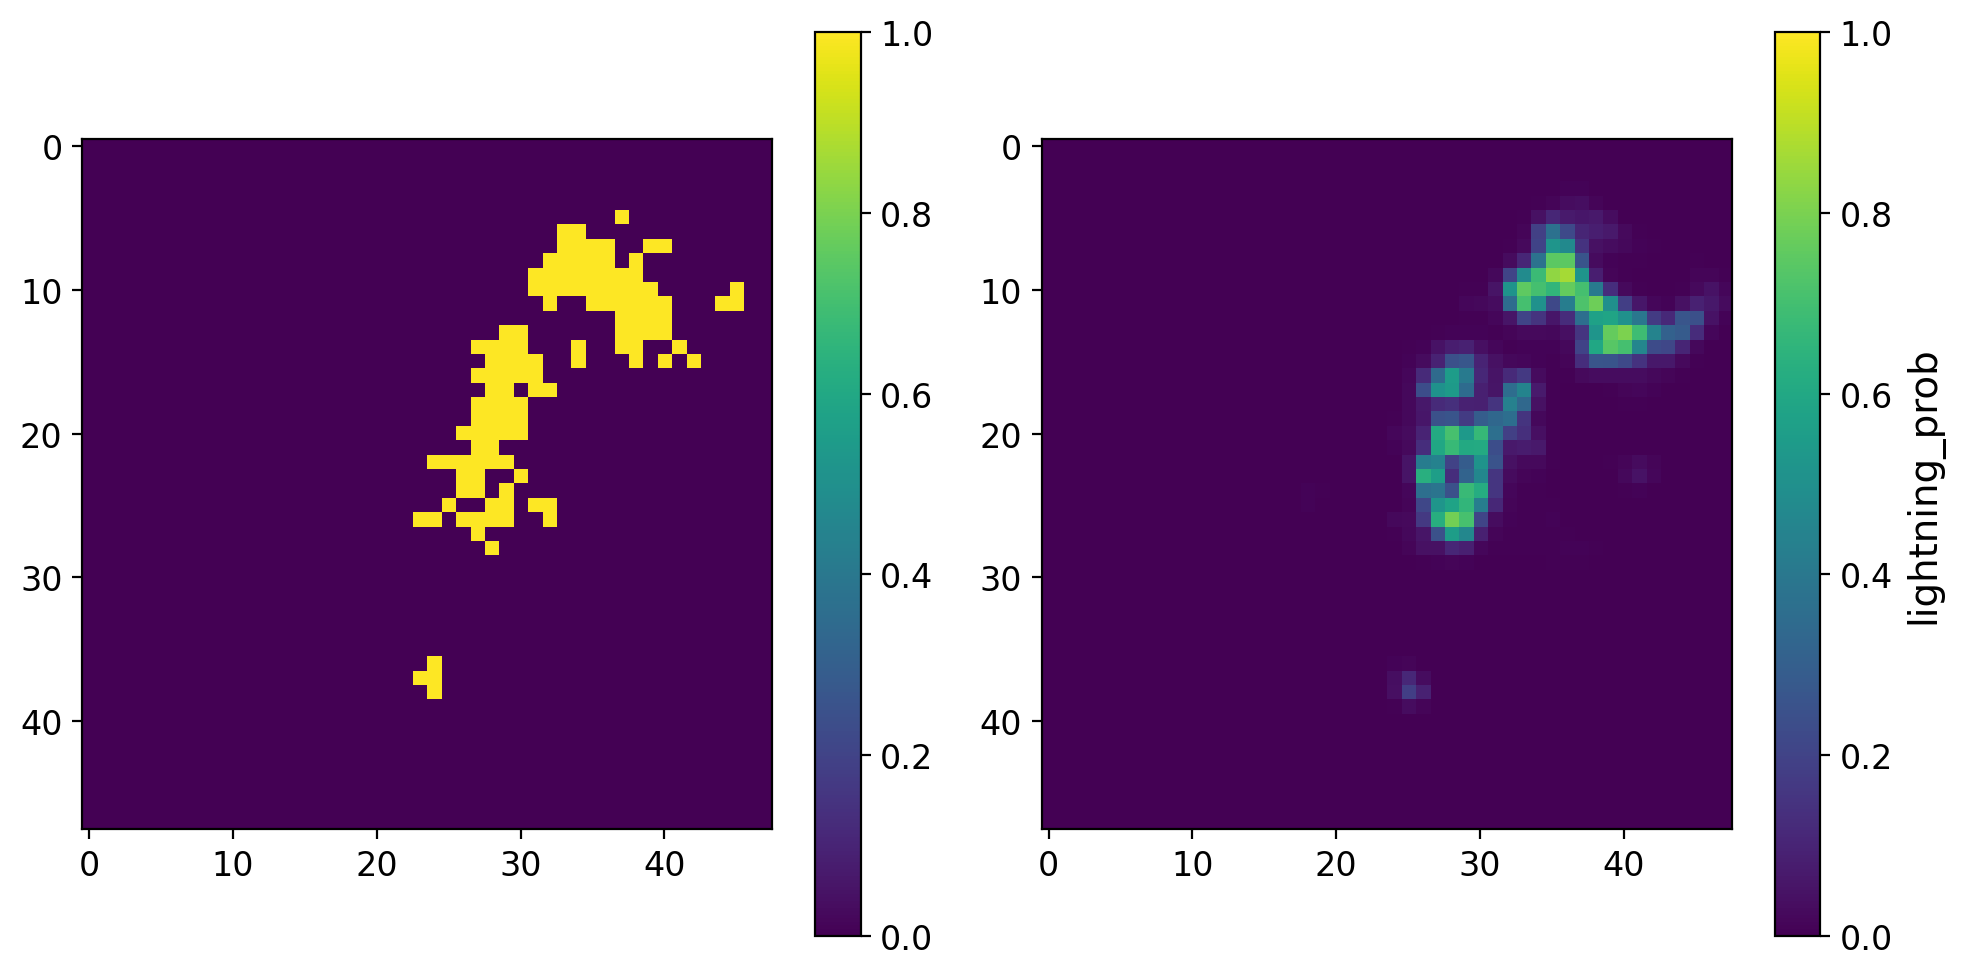

In [37]:
# Get example 27 from the new loader
val_features, val_label = val_dataset[27]

one_example_features = val_features.permute(1, 2, 0)
one_example_label = val_label.squeeze()
one_example_pred = y_preds[27].squeeze()

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(one_example_pred, vmin=0, vmax=1)
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()


The model batchsize=32 model makes lower probability preditctions for each lightning pixel in the image compared to the batchsize=64. Why does this happen? Perhaps because lightning is a rare event, the model was less able to learn to predict it (from fewer examples per batch) while still achieving decent scores in the context of the loss function. So how does increasing the batch size to 64 help fix this? One theory is that the larger batch size contains more examples of lightning, which then have a greater influence on the loss function. Furthermore, a batch size of 64 will provide a better estimate of the *true* gradient, which should lead to better weights and an improved loss function score.

This is probably more discussion than necessary for this tutorial, but we wanted to demonstrate that training these ML models is not always as straightforward as it appears. It can be very frustrating at times.

#### Step 9: Load the U-Net from the paper

In [22]:
pre_trained_unet_model_path = "./WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_paper/sub-sevir-unet-class-2d.pt"
pre_trained_unet_model = torch.jit.load(pre_trained_unet_model_path)
pre_trained_unet_model.eval()



RecursiveScriptModule(
  original_name=UNetClassifierFromPaper
  (down0_conv): RecursiveScriptModule(original_name=Conv2d)
  (down0_act): RecursiveScriptModule(original_name=ELU)
  (down1_pool): RecursiveScriptModule(original_name=MaxPool2d)
  (down1_conv): RecursiveScriptModule(original_name=Conv2d)
  (down1_act): RecursiveScriptModule(original_name=ELU)
  (down2_pool): RecursiveScriptModule(original_name=MaxPool2d)
  (down2_conv): RecursiveScriptModule(original_name=Conv2d)
  (down2_act): RecursiveScriptModule(original_name=ELU)
  (up0_upsample): RecursiveScriptModule(original_name=Upsample)
  (up0_conv_pre): RecursiveScriptModule(original_name=Conv2d)
  (up0_act_pre): RecursiveScriptModule(original_name=ELU)
  (up0_conv_post): RecursiveScriptModule(original_name=Conv2d)
  (up0_act_post): RecursiveScriptModule(original_name=ELU)
  (up1_upsample): RecursiveScriptModule(original_name=Upsample)
  (up1_conv_pre): RecursiveScriptModule(original_name=Conv2d)
  (up1_act_pre): RecursiveScrip

#### Step 10: make predictions with pre-trained model

(0.0, 1.0)

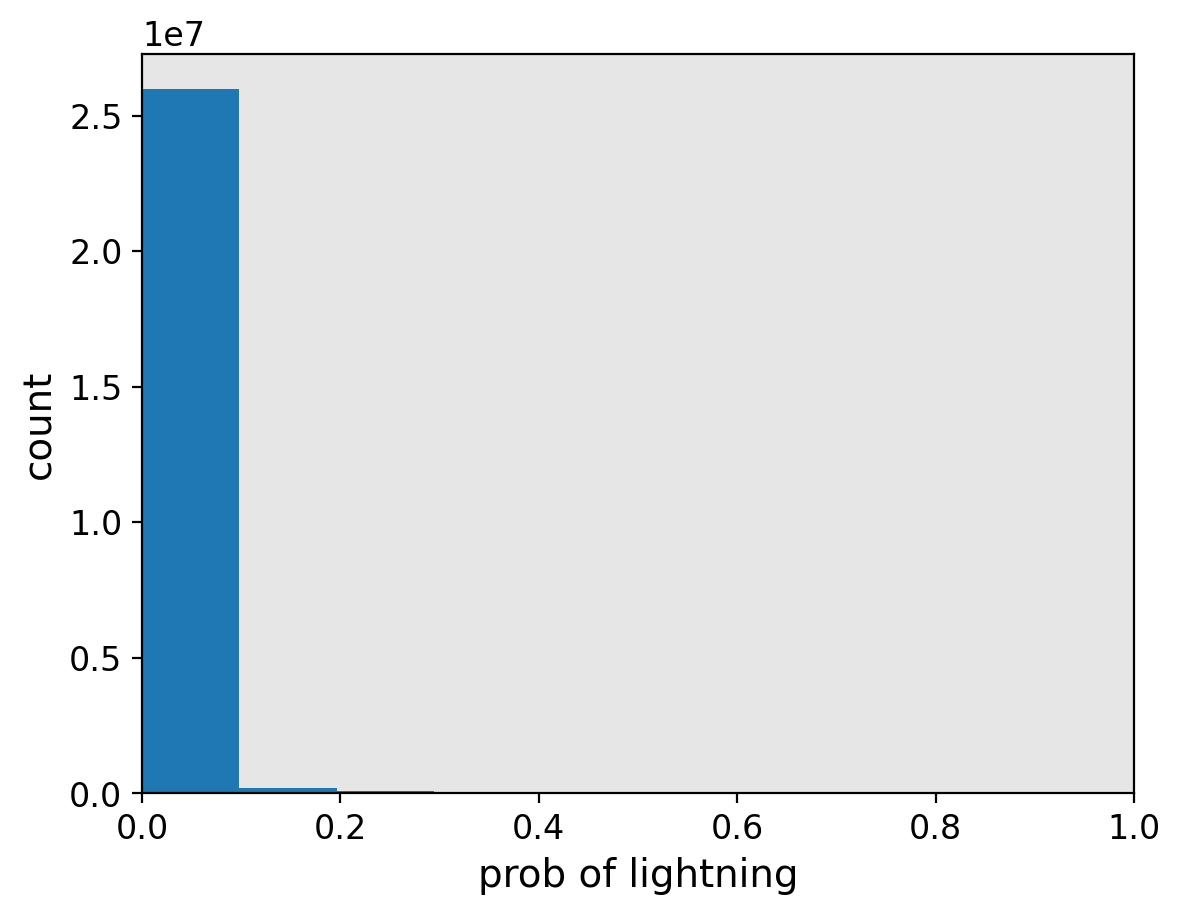

In [32]:
pre_trained_unet_model.to(device)
pretrained_y_preds = get_predictions(val_loader, pre_trained_unet_model)

plt.hist(pretrained_y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

#### Step 11: Make performance diagram with pre-trained model

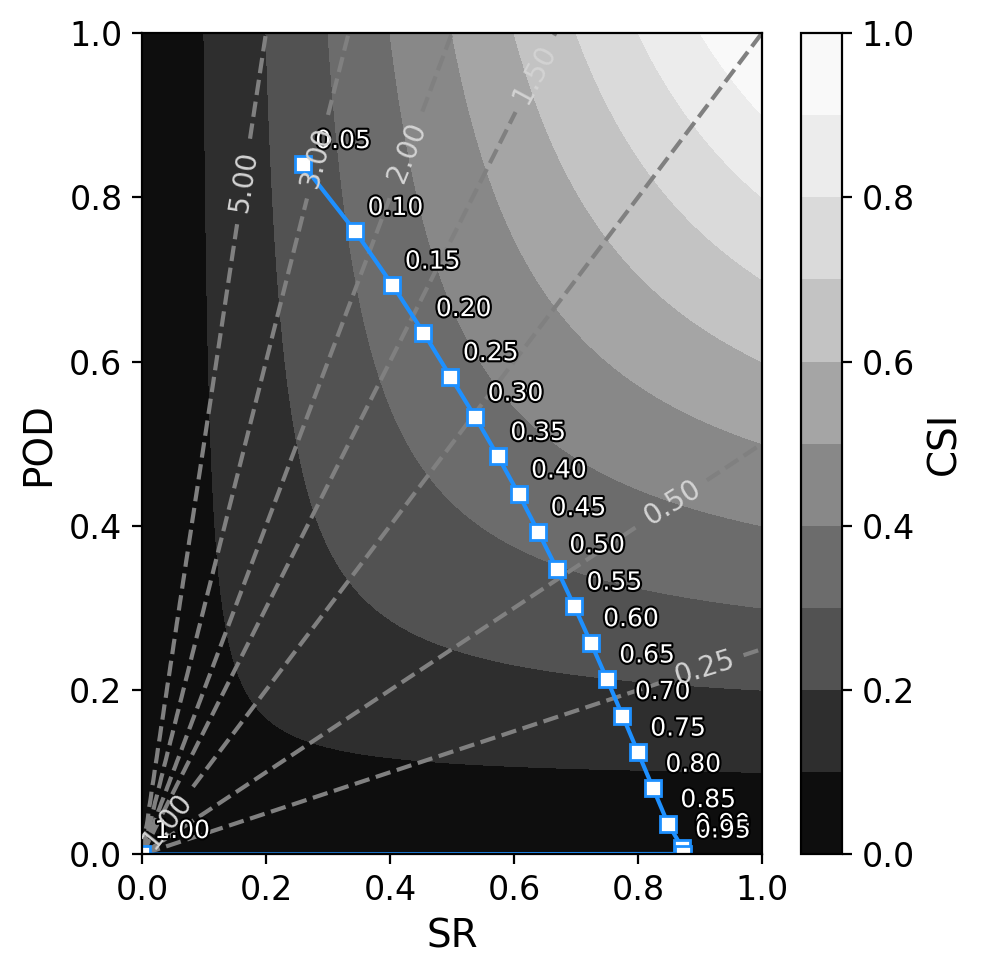

In [33]:
# Calculate stats manually for performance diagram
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

# This might be slow for pixel-wise calculation on the full array
# Ideally, use GPU or optimized metrics if available
for t in thresh:
    preds_bin = (pretrained_y_preds.ravel() >= t).astype(int)
    truth_bin = (y_v_rav == 1).astype(int)

    tp = np.sum((preds_bin == 1) & (truth_bin == 1))
    fp = np.sum((preds_bin == 1) & (truth_bin == 0))
    fn = np.sum((preds_bin == 0) & (truth_bin == 1))

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

# Avoid div by zero
with np.errstate(divide='ignore', invalid='ignore'):
    pods = tps/(tps + fns)
    srs = tps/(tps + fps)
    csis = tps/(tps + fns + fps)

pods = np.nan_to_num(pods)
srs = np.nan_to_num(srs)
csis = np.nan_to_num(csis)


#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods,'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(srs[i]+0.02, pods[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

Step 12: Examine specific inference from pre-trained model

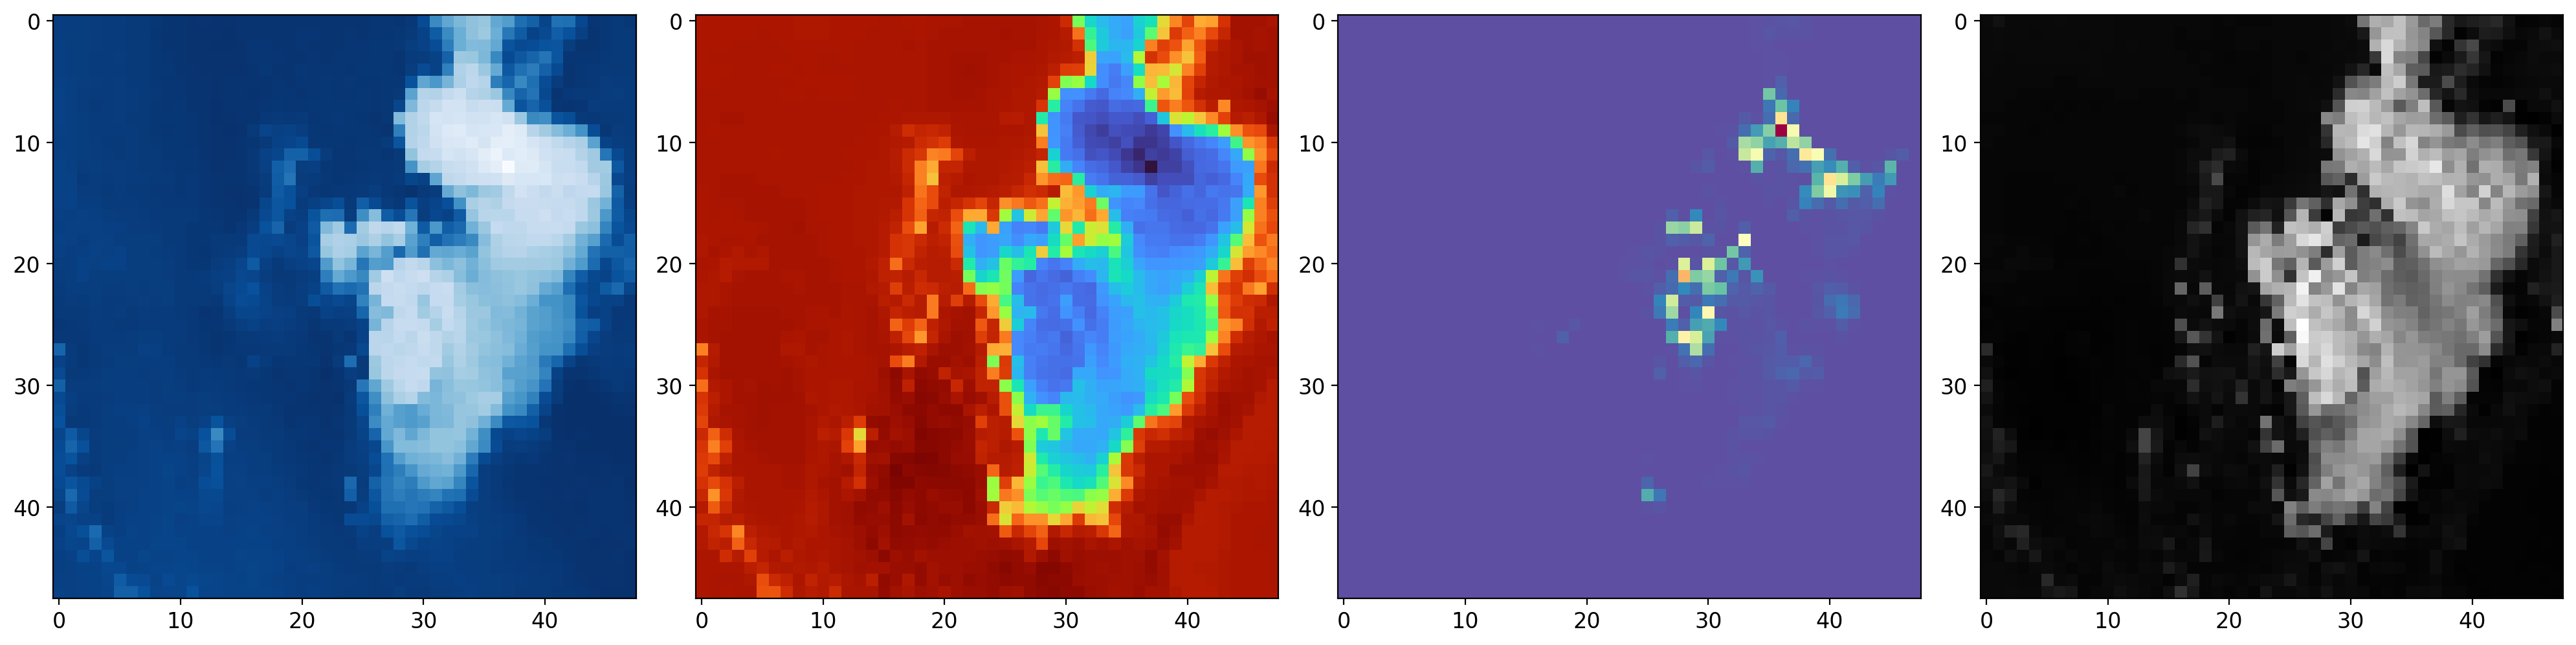

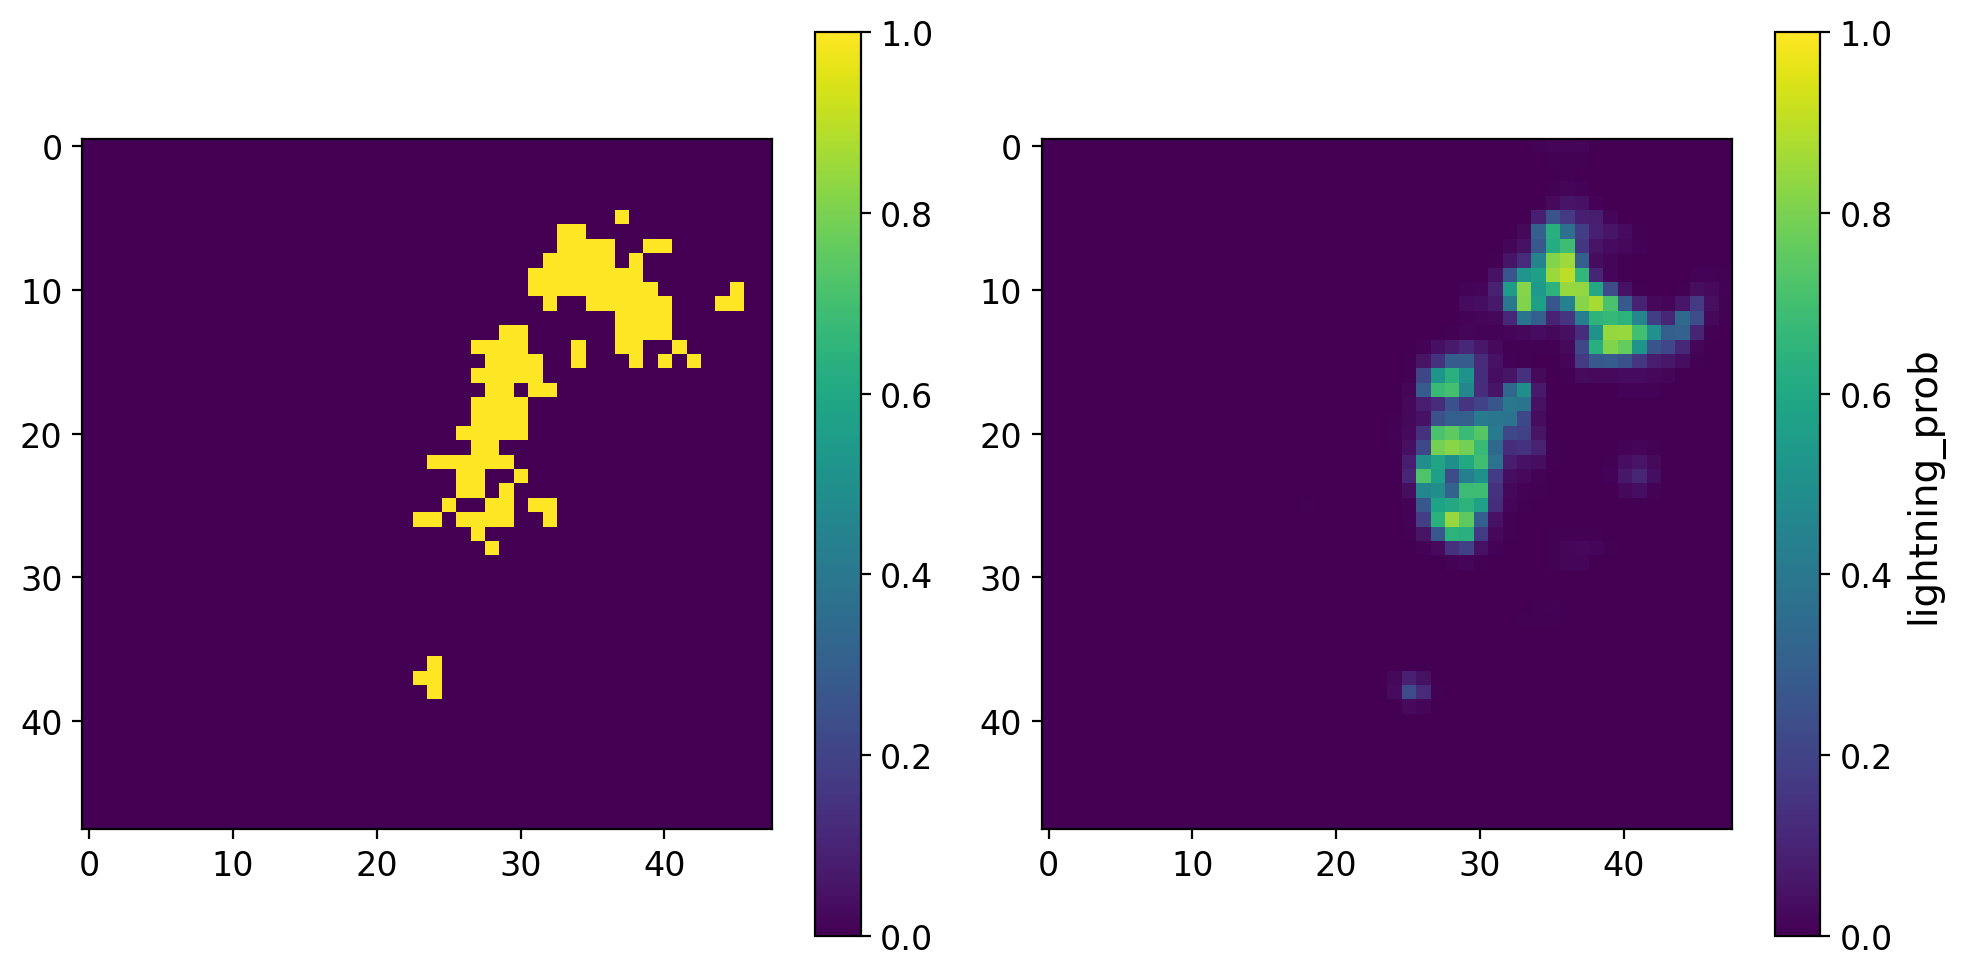

In [35]:
# Get example 27 from the new loader
val_features, val_label = val_dataset[27]

one_example_features = val_features.permute(1, 2, 0)
one_example_label = val_label.squeeze()
one_example_pred = pretrained_y_preds[27].squeeze()

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(one_example_pred, vmin=0, vmax=1)
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()
